<a href="https://colab.research.google.com/github/zal-developer/Intermediate-ML/blob/main/Zalwango_Diana_Project4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Metabolic Syndrome Prediction

In [11]:
#pandas and sklearn imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, r2_score
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

# Deep learning tols
!pip install keras_tuner
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout
from sklearn import set_config
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import HyperParameters as hp
import keras_tuner as kt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict



def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

In [13]:
# Load and preview data
fpath ="/content/drive/MyDrive/CodingDojo/05-IntermediateML/Week18/Data/Metabolic  Syndrome.csv"
df = pd.read_csv(fpath)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401 entries, 0 to 2400
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   seqn               2401 non-null   int64  
 1   Age                2401 non-null   int64  
 2   Sex                2401 non-null   object 
 3   Marital            2193 non-null   object 
 4   Income             2284 non-null   float64
 5   Race               2401 non-null   object 
 6   WaistCirc          2316 non-null   float64
 7   BMI                2375 non-null   float64
 8   Albuminuria        2401 non-null   int64  
 9   UrAlbCr            2401 non-null   float64
 10  UricAcid           2401 non-null   float64
 11  BloodGlucose       2401 non-null   int64  
 12  HDL                2401 non-null   int64  
 13  Triglycerides      2401 non-null   int64  
 14  MetabolicSyndrome  2401 non-null   object 
dtypes: float64(5), int64(6), object(4)
memory usage: 281.5+ KB


,seqn,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
0,62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,No MetSyn
1,62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,No MetSyn
2,62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,No MetSyn
3,62172,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,No MetSyn
4,62177,51,Male,Married,NaN,Asian,81.1,20.1,0,8.13,5.0,95,43,126,No MetSyn


## Explore/ clean the data

In [14]:
#checking null values
df.isnull().sum()

seqn                   0
Age                    0
Sex                    0
Marital              208
Income               117
Race                   0
WaistCirc             85
BMI                   26
Albuminuria            0
UrAlbCr                0
UricAcid               0
BloodGlucose           0
HDL                    0
Triglycerides          0
MetabolicSyndrome      0
dtype: int64

In [15]:
#checking % of missing values
df.isnull().sum()/len(df) * 100

seqn                 0.000000
Age                  0.000000
Sex                  0.000000
Marital              8.663057
Income               4.872970
Race                 0.000000
WaistCirc            3.540192
BMI                  1.082882
Albuminuria          0.000000
UrAlbCr              0.000000
UricAcid             0.000000
BloodGlucose         0.000000
HDL                  0.000000
Triglycerides        0.000000
MetabolicSyndrome    0.000000
dtype: float64

In [16]:
#dropping rows with nulls since they make a small % of the data
df.dropna(axis=0,inplace=True)
#checking for nulls
df.isnull().sum().sum()

0

In [17]:
#drop unnecessary columns
df = df.drop('seqn', axis=1)

In [18]:
# Count the duplicates
df.duplicated().sum()

0

In [19]:
#numerical summary
df.describe()

,Age,Income,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides
count,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000
mean,49.263813,4147.187656,98.524141,28.733499,0.147337,42.253375,5.491488,108.008462,53.551020,126.892982
std,17.421740,2984.597463,16.306348,6.580322,0.416533,241.419903,1.428865,33.636746,15.012329,89.818470
min,20.000000,300.000000,63.100000,15.700000,0.000000,1.400000,1.800000,39.000000,14.000000,26.000000
25%,35.000000,1600.000000,86.900000,24.100000,0.000000,4.460000,4.500000,92.000000,43.000000,75.000000
50%,49.000000,3500.000000,97.100000,27.700000,0.000000,6.960000,5.400000,100.000000,51.000000,103.000000
75%,63.000000,6200.000000,107.800000,32.100000,0.000000,13.490000,6.400000,110.000000,62.000000,149.000000
max,80.000000,9000.000000,170.500000,68.700000,2.000000,4462.810000,11.300000,382.000000,150.000000,1311.000000


In [20]:
#identifying object cols
string_cols=df.select_dtypes('object').columns
for col in string_cols:
#showing value counts for each object column
  print(f'value_counts for {col}')
  print(df[col].value_counts())
  print('\n')

value_counts for Sex
Sex
Female    1022
Male       987
Name: count, dtype: int64


value_counts for Marital
Marital
Married      1098
Single        460
Divorced      219
Widowed       144
Separated      88
Name: count, dtype: int64


value_counts for Race
Race
White          806
Black          462
Asian          295
MexAmerican    198
Hispanic       198
Other           50
Name: count, dtype: int64


value_counts for MetabolicSyndrome
MetabolicSyndrome
No MetSyn    1297
MetSyn        712
Name: count, dtype: int64




### Creating exploratory visualizations to understand your data and search for trends.

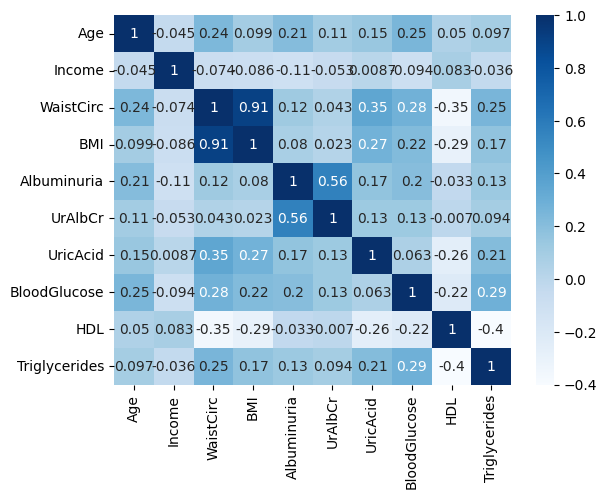

In [21]:
# Make a heatmap of correlations
# Get correlations
corr = df.corr(numeric_only = True)
# Include annotations on the heatmap
sns.heatmap(corr, cmap = 'Blues', annot = True);

- There is a very high positive correlation of 0.91 between BMI and WaistCirc which shows that as one increases so does the other.

- There is a very weak negative correlation between UrAlbCr and HDL which means there is no clear pattern between the two.

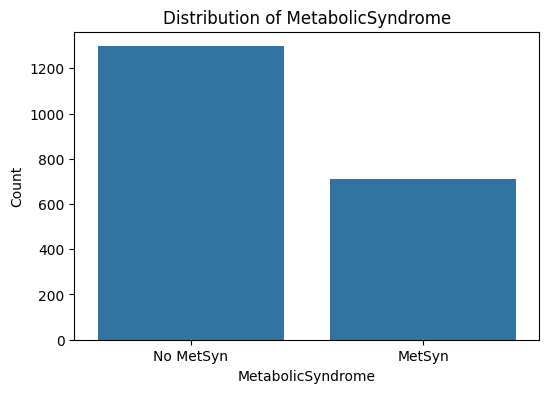

In [22]:
# Distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='MetabolicSyndrome', data=df)
plt.title('Distribution of MetabolicSyndrome')
plt.xlabel('MetabolicSyndrome')
plt.ylabel('Count')
plt.show()

- The patients are less than the healthy persons.

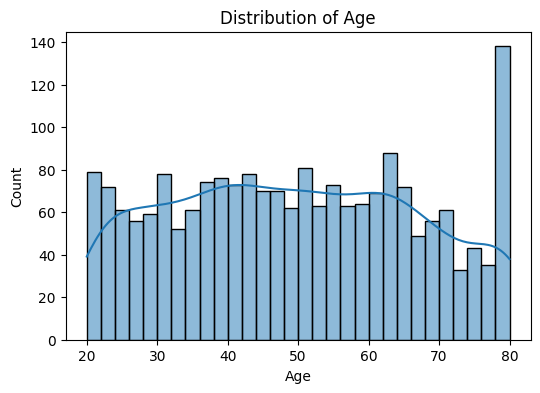

In [23]:
# Distribution of age
plt.figure(figsize=(6, 4))
sns.histplot(x='Age', data=df, bins=30, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

- The older persons in the 80year bin are more than all the age groups.
- The people seem to be distributed evenly across all age groups.

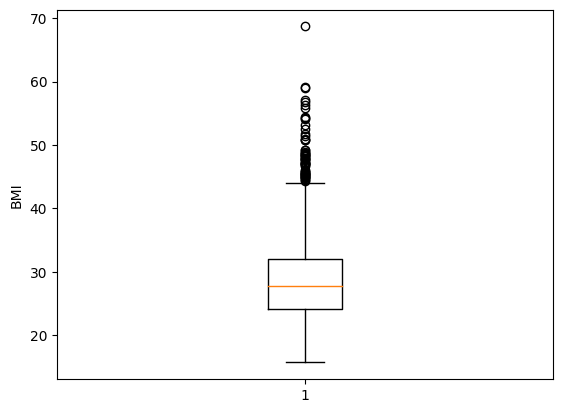

In [24]:
# create boxplot for BMI
fig, ax = plt.subplots()
data = df["BMI"]
ax.boxplot(data);
ax.set_ylabel("BMI");

- The average BMI is around 27,there also a number of outliers above 44.

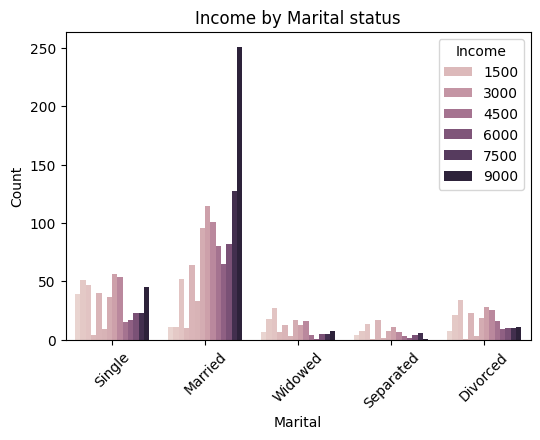

In [25]:
# Relationship between marital status and income
plt.figure(figsize=(6, 4))
sns.countplot(x='Marital', hue='Income', data=df)
plt.title('Income by Marital status')
plt.xlabel('Marital')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Income', loc='upper right')
plt.show()

- The married earn more income than all categories, mostly between 6000-9000.

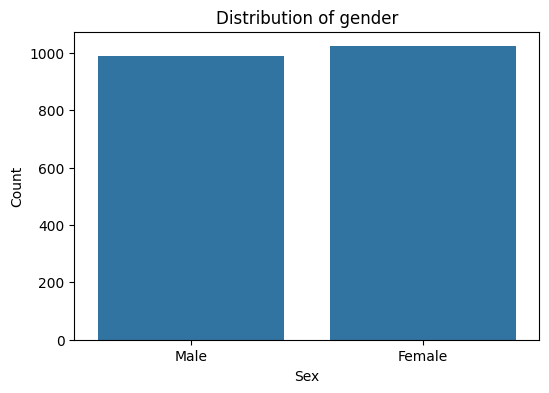

In [26]:
# Distribution of the gender
plt.figure(figsize=(6, 4))
sns.countplot(x='Sex', data=df)
plt.title('Distribution of gender')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

- the females are slightly more than the males.

### Choose a model

- Preprocess data

- Fit and evaluate a default model

In [27]:
# assign target y and features X
y = df['MetabolicSyndrome']
X = df.drop(columns = 'MetabolicSyndrome')
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)


In [28]:
# Define the categorical columns
ohe_cols = ['Sex', 'Marital', 'Race']

# Instantiate the OneHotEncoder
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Instantiate the pipeline
ohe_pipe = make_pipeline(ohe_encoder)

# Fit the pipeline on the training data
ohe_pipe.fit(X_train[ohe_cols])

# Transform the training and test data
X_train_ohe_tf = ohe_pipe.transform(X_train[ohe_cols])
X_test_ohe_tf = ohe_pipe.transform(X_test[ohe_cols])

# Convert the transformed data back to DataFrame
X_train_ohe_df = pd.DataFrame(X_train_ohe_tf, columns=ohe_pipe.named_steps['onehotencoder'].get_feature_names_out(ohe_cols))
X_test_ohe_df = pd.DataFrame(X_test_ohe_tf, columns=ohe_pipe.named_steps['onehotencoder'].get_feature_names_out(ohe_cols))

In [29]:
# Defining lists of types of features
num_cols = X_train.select_dtypes("number").columns
# instantiate preprocessors
scaler = StandardScaler()
num_pipe = make_pipeline(scaler)
# Fit the pipeline on the numeric training data
num_pipe.fit(X_train[num_cols])
# Transform the training data
X_train_num_tf = num_pipe.transform(X_train[num_cols])
# Transform the testing data
X_test_num_tf = num_pipe.transform(X_test[num_cols])
# Convert the transformed data back to DataFrame
X_train_num_df = pd.DataFrame(X_train_num_tf, columns=num_pipe.named_steps['standardscaler'].get_feature_names_out(num_cols))
X_test_num_df = pd.DataFrame(X_test_num_tf, columns=num_pipe.named_steps['standardscaler'].get_feature_names_out(num_cols))

In [30]:
# re-combine the 2 dataframes of training and test data
X_train_df = pd.concat([X_train_num_df, X_train_ohe_df], axis=1)
X_test_df = pd.concat([X_test_num_df, X_test_ohe_df], axis=1)

In [31]:
# Make an instance of the model with default parameters
logreg = LogisticRegression(max_iter=100, random_state=42)
# Instantiate Standard Scaler because scaling is required for logistic regression
scaler = StandardScaler()
# Put scaler and model in a pipeline
logreg_pipe = make_pipeline(scaler, logreg)
# Fit the logistic regression model on the combined training data
logreg_pipe.fit(X_train_df, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(random_state=42))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.82      0.74      0.78       531
   No MetSyn       0.87      0.91      0.89       975

    accuracy                           0.85      1506
   macro avg       0.84      0.82      0.83      1506
weighted avg       0.85      0.85      0.85      1506



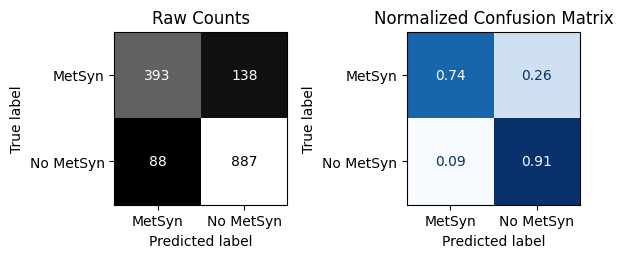


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.74      0.72      0.73       181
   No MetSyn       0.84      0.86      0.85       322

    accuracy                           0.81       503
   macro avg       0.79      0.79      0.79       503
weighted avg       0.81      0.81      0.81       503



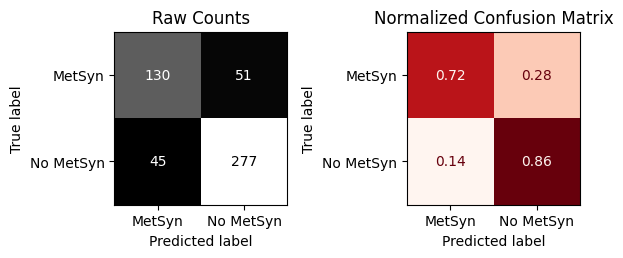

In [32]:
# Evaluate the default model
evaluate_classification(logreg_pipe, X_train_df, y_train, X_test_df, y_test)

- There is a high balanced performance across both classes due to the metrics in the test data.

#### Extract and visualize the top 10 features using permutation importance

In [33]:
from sklearn.inspection import permutation_importance

In [34]:
#computing permutation importance
result = permutation_importance(logreg_pipe, X_test_df, y_test, n_repeats=30, random_state=42)
#dataframe for feature importances
importances_df = pd.DataFrame({'feature': X_test_df.columns, 'importance': result.importances_mean})

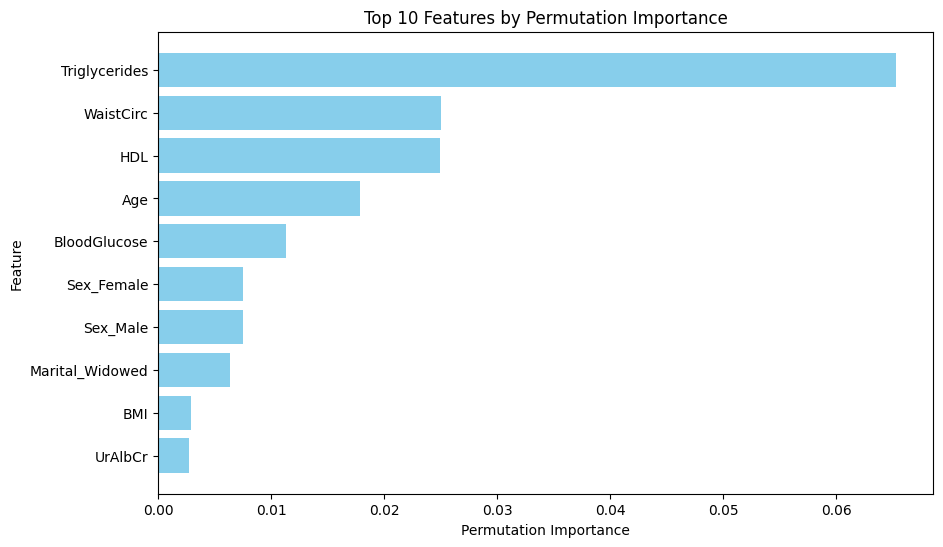

In [35]:
#sorting features by importance
importances_df = importances_df.sort_values(by='importance', ascending=False)
#extracting top 10 features
top_10_features = importances_df.head(10)
#visualize top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['feature'], top_10_features['importance'], color='skyblue')
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features by Permutation Importance')
plt.gca().invert_yaxis()
plt.show()

###  Add your observations in a Markdown: Do these features make sense based on the business case?

- Triglycerides: High levels of triglycerides are associated with an increased risk of metabolic syndrome.

- WaistCirc: Waist circumference is a measure of abdominal obesity, which is strongly associated with metabolic syndrome.

- HDL: Low levels of HDL cholesterol are associated with an increased risk of metabolic syndrome.

- Age: Higher age is a known risk factor for metabolic syndrome.

- BloodGlucose: High blood glucose levels are a key characteristic of metabolic syndrome.

- BMI:Higher levels of BMI could pose a higher risk of metabolic syndrome.

- Sex:The prevalence of metabolic syndrome in females is higher than in men.

- UrAlbCr: Higher levels of UrAlbCr are associated with metabolic syndrome.


#### Select 2 out of the top 10 features from your permutation importances and produce explanatory visualizations showing the relationship between the feature and the target.

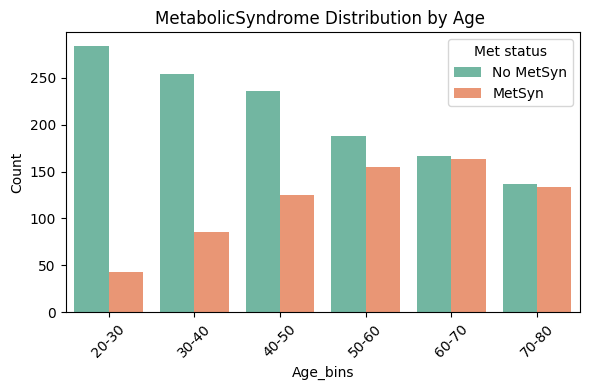

In [36]:
# Create a bar plot for age vs target
Age_bins = [20, 30, 40, 50, 60, 70, 80]
df['Age_Binned'] = pd.cut(df['Age'], bins=Age_bins, labels=[f'{Age_bins[i]}-{Age_bins[i+1]}' for i in range(len(Age_bins)-1)])
plt.figure(figsize=(6, 4))
sns.countplot(x='Age_Binned', hue='MetabolicSyndrome', data=df, palette='Set2')
plt.title('MetabolicSyndrome Distribution by Age ')
plt.xlabel('Age_bins')
plt.ylabel('Count')
plt.legend(title='Met status')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- the age groups of 20-40 have the highest number of people who donot have metabolic syndrome while the age groups of 60-80 have the highest number of people who have metabolic syndrome.

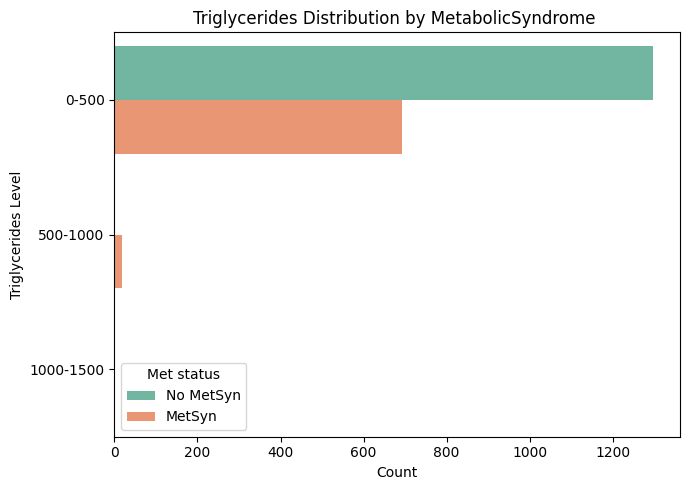

In [37]:
# Create a count plot for Triglycerides vs Income target
# Create triglycerides bins
triglycerides_bins = [0, 500,  1000, 1500]
df['Triglycerides_Binned'] = pd.cut(df['Triglycerides'], bins=triglycerides_bins, labels=[f'{triglycerides_bins[i]}-{triglycerides_bins[i+1]}' for i in range(len(triglycerides_bins)-1)])
#plotting
plt.figure(figsize=(7, 5))
sns.countplot(y='Triglycerides_Binned', hue='MetabolicSyndrome', data=df, palette='Set2')
plt.title('Triglycerides Distribution by MetabolicSyndrome ')
plt.xlabel('Count')
plt.ylabel('Triglycerides Level')
plt.legend(title='Met status')
plt.tight_layout()
plt.show()

- People with low levels of Triglycerides seem to be more associated with high levels of negative metabolic syndrome status.

#### Apply PCA to get 3 principal components for the data. Concatenate/combine these PC’s with the original features (X_train, X_test data).

​Remember to only fit the PCA on the training data and use pca.transform(X_test) to get the PCs for the testing data.


In [38]:
from sklearn.decomposition import PCA

# Apply PCA to get 3 principal components for the data
pca = PCA(n_components=3, random_state=42)

# Fit PCA on the training data
pca.fit(X_train_df)

# Transform both training and testing data
X_train_pca = pca.transform(X_train_df)
X_test_pca = pca.transform(X_test_df)


#### Create additional features by applying the feature engineering techniques demonstrated in the LP.

Fit and evaluate a model using your new features and compare it to your model from Part 1.


In [39]:
from sklearn.model_selection import train_test_split

# Add the new features to the feature matrix
df['Age_Category'] = df['Age'].apply(lambda x: 'elderly' if x > 30 else 'young')
df['BMI_WaistCirc'] = df['BMI'] * df['WaistCirc']
df.drop(['Age', 'BMI','WaistCirc'], axis=1, inplace=True)

# Select features and target
X = df[['Age_Category', 'BMI_WaistCirc']]
y = df['MetabolicSyndrome']

# Split data into train and test sets, ensuring that 'Age_Category' is used in the stratification process
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42, stratify=df['Age_Category'])

encoder = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)


# Make an instance of the model with default parameters
logreg_new_features = LogisticRegression(max_iter=100, random_state=42)

# Fit the logistic regression model on the new features
logreg_new_features.fit(X_train_encoded, y_train)


LogisticRegression(random_state=42)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       1.00      0.92      0.96       525
   No MetSyn       0.96      1.00      0.98       981

    accuracy                           0.97      1506
   macro avg       0.98      0.96      0.97      1506
weighted avg       0.97      0.97      0.97      1506



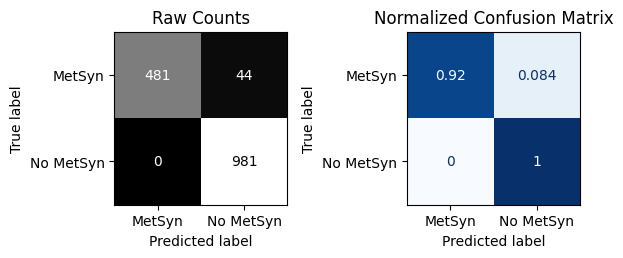


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.00      0.00      0.00       187
   No MetSyn       0.63      1.00      0.77       316

    accuracy                           0.63       503
   macro avg       0.31      0.50      0.39       503
weighted avg       0.39      0.63      0.48       503



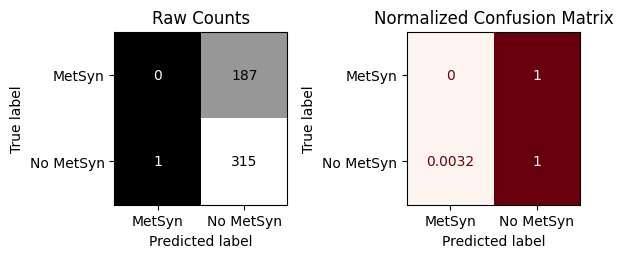

In [40]:
# Evaluate the default model
evaluate_classification(logreg_new_features, X_train_encoded, y_train, X_test_encoded, y_test)

- This model has a lower accuracy(0.63) than model in part 1 and it has zero precision,recall and f1-score.

Apply at least one method of feature selection (filtering, embedded, wrapper) to your new features including engineered data.

In [41]:
from sklearn.feature_selection import VarianceThreshold

# Set the threshold for variance
threshold = 0.01  # You can adjust this threshold as needed

# Instantiate the VarianceThreshold selector
selector = VarianceThreshold(threshold=threshold)

# Fit the selector to the training data
selector.fit(X_train_encoded)

# Get the support array indicating which features to keep
keep_features = selector.get_support()

# Number of features to keep (non-quasi-constant features)
num_features_to_keep = keep_features.sum()

print("Number of features to keep (non-quasi-constant features):", num_features_to_keep)


Number of features to keep (non-quasi-constant features): 1


In [42]:
# Filter based on variance
X_train_filtered = X_train_encoded[:, keep_features]
X_test_filtered = X_test_encoded[:, keep_features]

Fit and evaluate a final model using the selected features. Compare it with previous models

In [43]:
# Instantiate the logistic regression model
logreg_last= LogisticRegression(max_iter=100, random_state=42)

# Fit the model on the selected features
logreg_last.fit(X_train_filtered, y_train)

LogisticRegression(random_state=42)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.00      0.00      0.00       525
   No MetSyn       0.65      1.00      0.79       981

    accuracy                           0.65      1506
   macro avg       0.33      0.50      0.39      1506
weighted avg       0.42      0.65      0.51      1506



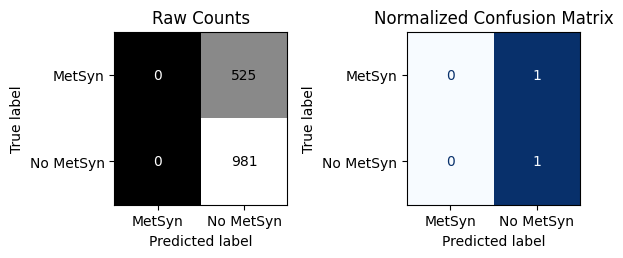


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.00      0.00      0.00       187
   No MetSyn       0.63      1.00      0.77       316

    accuracy                           0.63       503
   macro avg       0.31      0.50      0.39       503
weighted avg       0.39      0.63      0.48       503



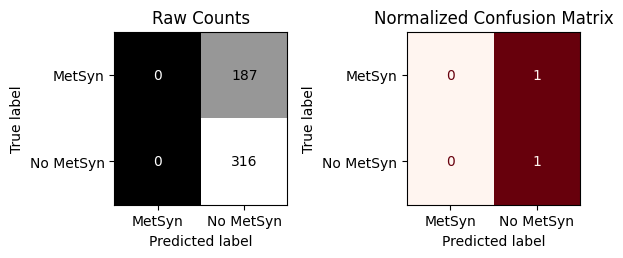

In [44]:
# Evaluate the default model
evaluate_classification(logreg_last, X_train_filtered, y_train, X_test_filtered, y_test)

- It is not suitable for predicting the "MetSyn" class due to  inability to identify any cases.
- It has the same average accuracy score like model 2.


Extract and visualize the top 10 features using permutation importance

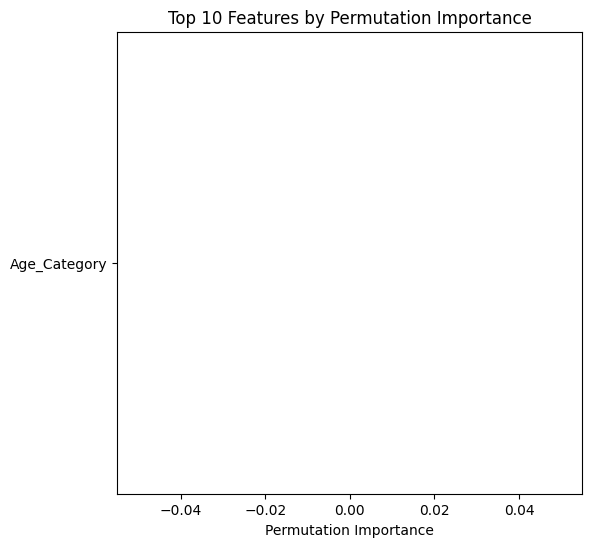

In [45]:
# Compute permutation importance
perm_importance = permutation_importance(logreg_last, X_test_filtered, y_test, n_repeats=10, random_state=42)

# Get the sorted indices of feature importance
sorted_idx = perm_importance.importances_mean.argsort()[-10:]

# Get the names of the top 10 features
top_10_features = X_train.columns[sorted_idx]

# Plot the permutation importance
plt.figure(figsize=(6, 6))
plt.barh(top_10_features, perm_importance.importances_mean[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Top 10 Features by Permutation Importance')
plt.show()

In a Markdown cell, comment on how these features compare to the model from Part 1. Are there any new features in the top 10?


### There is a new lone feature-Age-Category



---



# PART 3

​Build a small neural network (with only 1 hidden layer)

Ensure the final layer is appropriate for your task (number of units and activation function).

Fit it for 50 epochs

Use the Early Stopping callback

Start with patience =5 monitoring val_accuracy.

Use a validation_split of .2

Save the history and visualize it.

In [46]:
# Perform the replacement directly on the Series
y_train.replace(['MetSyn', 'No MetSyn'], [1, 0], inplace=True)
y_test.replace(['MetSyn', 'No MetSyn'], [1, 0], inplace=True)

In [47]:
# Custom function for plotting each metric
def plot_history(history, figsize=(6,8), marker='o'):

    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]

    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)

    # For each metric
    for i, metric_name in enumerate(metrics):

        # Get the axis for the current metric
        ax = axes[i]

        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch

        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)

        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)

        # Final subplot adjustments
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes

In [48]:
# Scale data
scaler = StandardScaler()
scaler.fit(X_train_filtered)
X_train_tf = scaler.transform(X_train_filtered)
X_test_tf = scaler.transform(X_test_filtered)

In [49]:
# Save the number of features we have as our input shape
input_shape = X_train_tf.shape[1]
input_shape

1

In [62]:
# Build binary classification model within function
def build_model():
    # Instantiate Model
    model = Sequential()

    # First hidden layer
    model.add(Dense(5,
                input_dim =input_shape,
                activation = 'relu'))
    #output layer
    model.add(Dense(1, activation = 'sigmoid'))

    # Compile Model
    model.compile(loss = 'bce', optimizer = 'adam',
             metrics=['accuracy', metrics.Precision(), metrics.Recall()])
    return model


In [63]:
# Call our build function to build model
clf_model = build_model()

# Get model summary
clf_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 5)                 10        
                                                                 
 dense_6 (Dense)             (None, 1)                 6         
                                                                 
Total params: 16 (64.00 Byte)
Trainable params: 16 (64.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [64]:
#early stopping
early_stop = EarlyStopping(monitor='val_accuracy', patience=5)

In [65]:
#fit model on the data
history = clf_model.fit(X_train_tf, y_train,
                        validation_split=.2,
                        epochs=50,
                        verbose=0, callbacks = [early_stop])


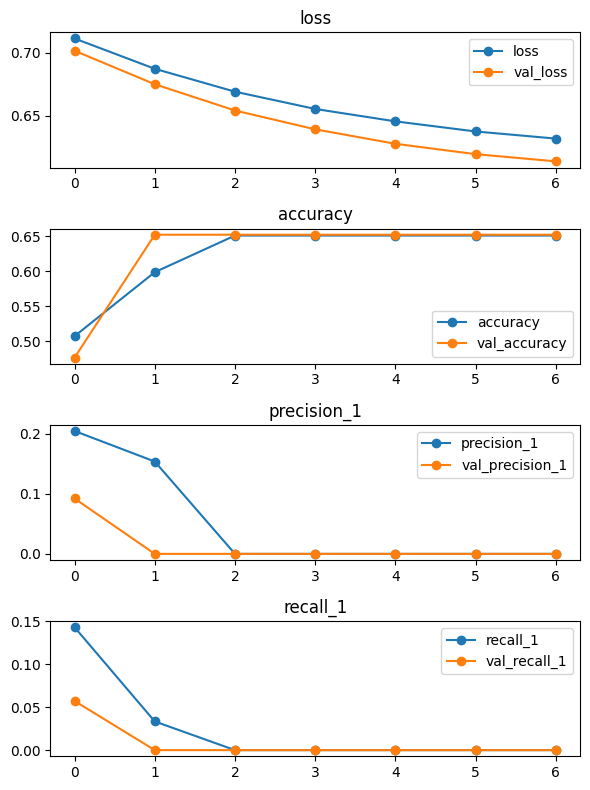

In [66]:
# plot learning history
plot_history(history);

Evaluate the model using sklearn evaluation metrics:

Confusion Matrix

Classification Report

In [67]:
# make predictions
y_pred_test = clf_model.predict(X_test_tf)
y_pred_test[:5]

16/16 [==============================] - 0s 4ms/step


array([[0.42904937],
       [0.42904937],
       [0.42904937],
       [0.23185556],
       [0.42904937]], dtype=float32)

In [68]:
# round the predictions
y_pred_test = np.round(y_pred_test)
y_pred_test[:5]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

              precision    recall  f1-score   support

           0       0.63      1.00      0.77       316
           1       0.00      0.00      0.00       187

    accuracy                           0.63       503
   macro avg       0.31      0.50      0.39       503
weighted avg       0.39      0.63      0.48       503



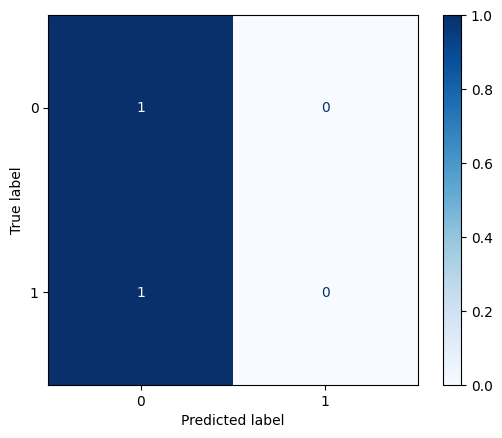

In [69]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
print(classification_report(y_test, y_pred_test))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, cmap='Blues',
                                       normalize='true');


Tune at least 3 parameters with the Keras tuner:

Include a dropout layer and adjust the dropout rate.

Number of Units

Optimizer

Learning rates


In [58]:
# Make a folder to store results of hyperparameter tuning
import os
folder = 'KerasTuner/'
os.makedirs(folder, exist_ok=True)

In [82]:
# Build and Compile Model within a function to try different optimizers, units, and dropout values
def build_model(hp):
    # Instantiate Model
    model = Sequential()
    # First hidden layer
    model.add(Dense(3,
                input_dim =input_shape,
                activation = 'relu'))
    # Try different values for units
    model.add(Dense(units=hp.Int('units', min_value=10, max_value=50, step=5), activation='relu'))
    # Try different values for dropout rate
    model.add(Dropout(hp.Float(name="dropout_value", min_value=0.0, max_value=0.8, step=0.2)))
    model.add(Dense(1, activation = 'sigmoid'))

    # Compile Model
    model.compile(optimizer=hp.Choice('optimizer',['rmsprop','nadam','adam']),
                  loss='bce',
                  metrics=['accuracy',
                           tf.keras.metrics.Recall(name='recall'),
                           tf.keras.metrics.Precision(name='precision')])
    return model

In [83]:
# Define tuner object
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     directory=folder,
                     overwrite = True,
                     seed = 42,
                     project_name='MetSyn_tuning')

In [84]:

early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [85]:
# Run the tuner
epochs = 100
tuner.search(X_train_tf, y_train,  epochs=epochs,
             validation_data = (X_test_tf, y_test), callbacks = [early_stop],verbose=0)

In [86]:
# Obtain best hyperparameter values
best_hps = tuner.get_best_hyperparameters()[0]
best_hps.values

{'units': 35,
 'dropout_value': 0.0,
 'optimizer': 'nadam',
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 2,
 'tuner/round': 0}

In [87]:
# Obtain best model
best_model = tuner.get_best_models()[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 6         
                                                                 
 dense_1 (Dense)             (None, 35)                140       
                                                                 
 dropout (Dropout)           (None, 35)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 36        
                                                                 
Total params: 182 (728.00 Byte)
Trainable params: 182 (728.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [88]:
# Evaluate neural network with tuned optimizer, units, and dropout
result = best_model.evaluate(X_test_tf, y_test, return_dict=True)
result

16/16 [==============================] - 0s 4ms/step - loss: 0.6426 - accuracy: 0.6282 - recall: 0.0000e+00 - precision: 0.0000e+00


{'loss': 0.6425641179084778,
 'accuracy': 0.628230631351471,
 'recall': 0.0,
 'precision': 0.0}